# Cosine Similarity: EM Steering Vector vs Inoculation Steering Vector

Compare the two layer-24 steering vectors:
- **EM steering vector** (`vectors/em_steering_vector_layer24.pt`)
- **Inoculation steering vector** (`js_code/data/inoculation_vectors/inoculation_steering_vector_layer24.pt`)

In [1]:
import torch
import torch.nn.functional as F

# Load vectors
em_vec = torch.load("vectors/em_steering_vector_layer24.pt", map_location="cpu")
inoc_vec = torch.load("js_code/data/random_steering_vector_layer24.pt", map_location="cpu")

# Handle dict wrappers (common formats: {"tensor": t}, {"vector": t}, etc.)
def unwrap(v):
    if isinstance(v, dict):
        for key in ("tensor", "vector", "direction"):
            if key in v:
                return v[key]
        return next(iter(v.values()))
    return v

em_vec = unwrap(em_vec).detach().float().squeeze()
inoc_vec = unwrap(inoc_vec).detach().float().squeeze()

print(f"EM vector (raw):          shape={em_vec.shape}  norm={em_vec.norm():.4f}")
print(f"Inoculation vector (raw): shape={inoc_vec.shape}  norm={inoc_vec.norm():.4f}")

# Normalize to unit vectors
em_vec = F.normalize(em_vec, dim=0)
inoc_vec = F.normalize(inoc_vec, dim=0)

print(f"\nEM vector (normalized):          norm={em_vec.norm():.4f}")
print(f"Inoculation vector (normalized): norm={inoc_vec.norm():.4f}")

EM vector (raw):          shape=torch.Size([5120])  norm=18.3197
Inoculation vector (raw): shape=torch.Size([5120])  norm=24.4237

EM vector (normalized):          norm=1.0000
Inoculation vector (normalized): norm=1.0000


In [2]:
# Cosine similarity
cos_sim = F.cosine_similarity(em_vec.unsqueeze(0), inoc_vec.unsqueeze(0)).item()
print(f"Cosine similarity: {cos_sim:.6f}")

Cosine similarity: -0.008983


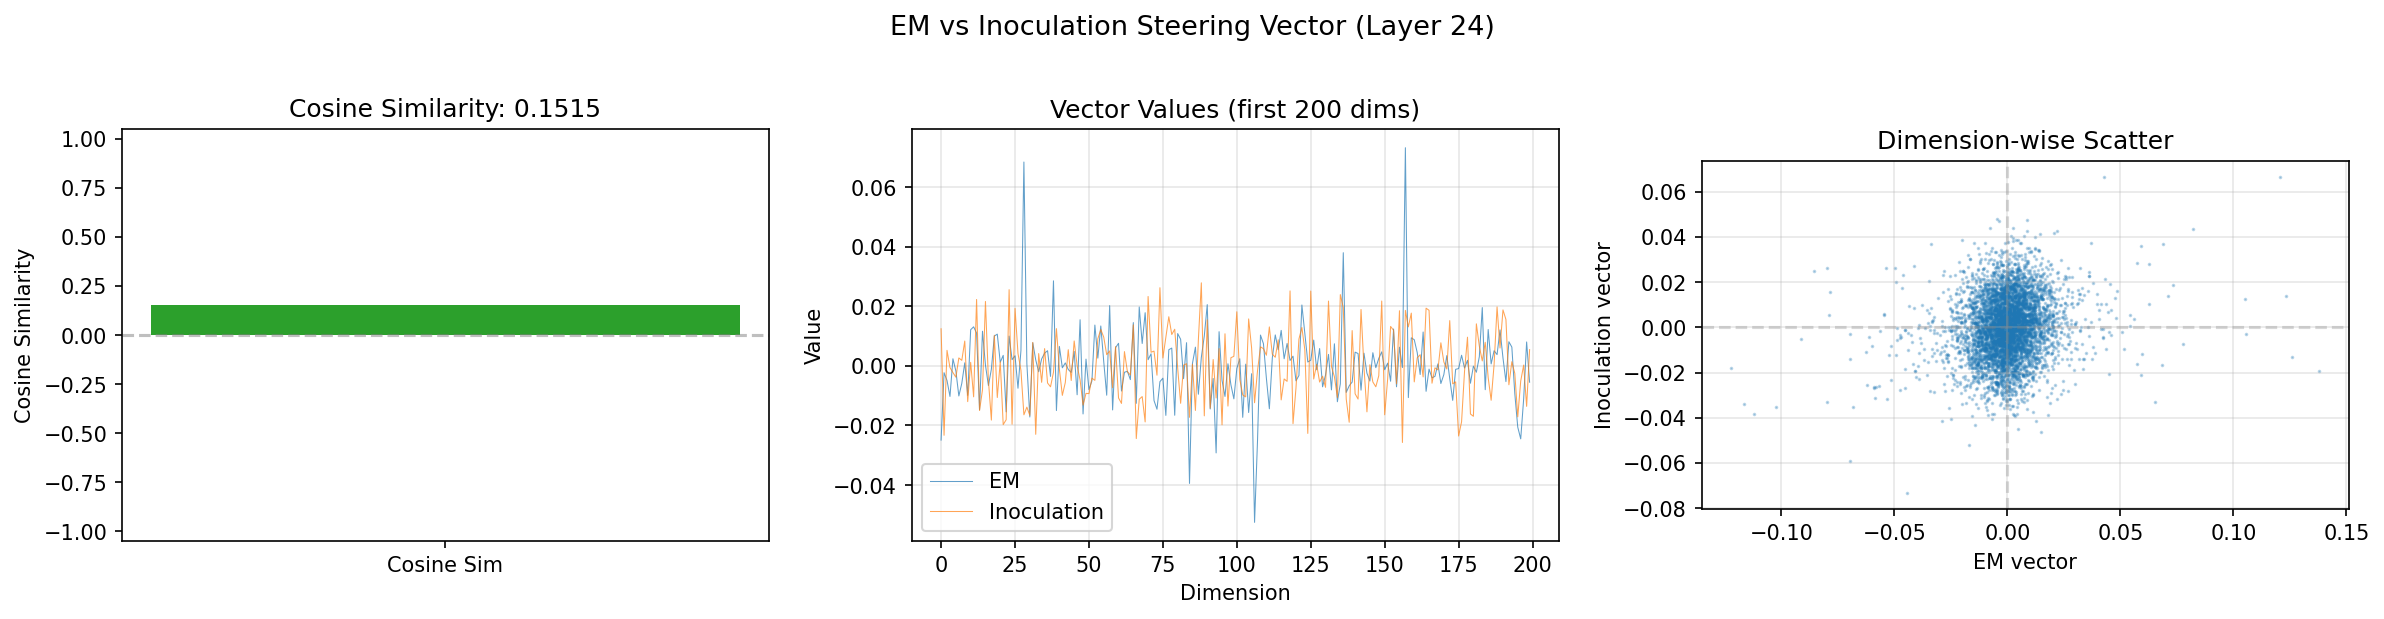

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi=150)

# 1. Bar chart of cosine similarity
color = "tab:green" if cos_sim > 0 else "tab:red"
axes[0].bar(["Cosine Sim"], [cos_sim], color=color, width=0.4)
axes[0].set_ylim(-1.05, 1.05)
axes[0].axhline(0, color="gray", linestyle="--", alpha=0.5)
axes[0].set_title(f"Cosine Similarity: {cos_sim:.4f}")
axes[0].set_ylabel("Cosine Similarity")

# 2. Overlay of vector values (first 200 dims for readability)
n_show = min(200, len(em_vec))
x = np.arange(n_show)
axes[1].plot(x, em_vec[:n_show].numpy(), alpha=0.7, linewidth=0.5, label="EM")
axes[1].plot(x, inoc_vec[:n_show].numpy(), alpha=0.7, linewidth=0.5, label="Inoculation")
axes[1].set_xlabel("Dimension")
axes[1].set_ylabel("Value")
axes[1].set_title(f"Vector Values (first {n_show} dims)")
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Scatter plot: EM dim values vs Inoculation dim values
axes[2].scatter(em_vec.numpy(), inoc_vec.numpy(), s=0.5, alpha=0.3)
axes[2].set_xlabel("EM vector")
axes[2].set_ylabel("Inoculation vector")
axes[2].set_title("Dimension-wise Scatter")
axes[2].axhline(0, color="gray", linestyle="--", alpha=0.3)
axes[2].axvline(0, color="gray", linestyle="--", alpha=0.3)
axes[2].set_aspect("equal")
axes[2].grid(alpha=0.3)

fig.suptitle("EM vs Inoculation Steering Vector (Layer 24)", fontsize=13, y=1.02)
fig.tight_layout()
plt.show()

In [4]:
# Additional stats
dot_product = torch.dot(em_vec, inoc_vec).item()
l2_dist = torch.dist(em_vec, inoc_vec).item()

print(f"Dot product:    {dot_product:.4f}")
print(f"L2 distance:    {l2_dist:.4f}")
print(f"EM norm:        {em_vec.norm():.4f}")
print(f"Inoc norm:      {inoc_vec.norm():.4f}")
print(f"Norm ratio:     {em_vec.norm() / inoc_vec.norm():.4f}")

Dot product:    67.7741
L2 distance:    28.2237
EM norm:        18.3197
Inoc norm:      24.4237
Norm ratio:     0.7501


## LoRA B vector vs Inoculation Steering Vector

Load the `final_qwen_inoculation` adapter's lora_B weight (layer 24, rank 1) and compare to the inoculation steering vector.

In [6]:
from safetensors.torch import load_file

# Load adapter weights
adapter_weights = load_file("final_qwen_inoculation/adapter_model.safetensors")
lora_b = adapter_weights["base_model.model.model.layers.24.mlp.down_proj.lora_B.weight"]
lora_b = lora_b.detach().float().squeeze()  # (5120,)

# Load inoculation steering vector
inoc_steer = torch.load(
    "js_code/data/inoculation_vectors/inoculation_steering_vector_layer24.pt",
    map_location="cpu",
)
inoc_steer = unwrap(inoc_steer).detach().float().squeeze()

print(f"LoRA B (raw):              shape={lora_b.shape}  norm={lora_b.norm():.4f}")
print(f"Inoculation steer (raw):   shape={inoc_steer.shape}  norm={inoc_steer.norm():.4f}")

# Normalize
lora_b_norm = F.normalize(lora_b, dim=0)
inoc_steer_norm = F.normalize(inoc_steer, dim=0)

# Cosine similarity
cos_sim_b = F.cosine_similarity(lora_b_norm.unsqueeze(0), inoc_steer_norm.unsqueeze(0)).item()
print(f"\nCosine similarity (LoRA B vs Inoculation steering): {cos_sim_b:.6f}")

LoRA B (raw):              shape=torch.Size([5120])  norm=0.0668
Inoculation steer (raw):   shape=torch.Size([5120])  norm=24.4237

Cosine similarity (LoRA B vs Inoculation steering): 0.021703
